In [1]:
import numpy as np
import pandas as pd
from feature_engine.selection import SmartCorrelatedSelection
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SequentialFeatureSelector
import scorecardpy as sc
import pickle
from sklearn.pipeline import Pipeline
from data_preparation.additional_transformers import GiniSelector

In [2]:
train_data=pd.read_pickle("./Intermidiate_data/train_woe_binning.pk")
test_data=pd.read_pickle("./Intermidiate_data/test_woe_binning.pk")

In [3]:
x_train=train_data.drop('target',axis=1)
x_test=test_data.drop('target',axis=1)
y_train=train_data['target']
y_test=test_data['target']

In [4]:
model = LogisticRegression(penalty=None)

pipe = Pipeline([
    ('Delete features with gini lower than 0.01', GiniSelector(0.01)), 
    ('Smart Correlated Selection', SmartCorrelatedSelection( variables=None,
                                                             method="pearson",
                                                             threshold=0.8,
                                                             missing_values="raise",
                                                             selection_method="variance",
                                                             estimator=None,).set_output(transform="pandas")),
    ('Sequential Feature Selector', SequentialFeatureSelector(model, 
                                                              n_features_to_select='auto', 
                                                              tol=0.005, 
                                                              scoring='roc_auc', 
                                                              cv=5).set_output(transform="pandas")),
    ('Logistic regression', model)
])
pipe.fit(x_train, y_train)

Pipeline(steps=[('Delete features with gini lower than 0.01',
                 GiniSelector(threshold=0.01)),
                ('Smart Correlated Selection',
                 SmartCorrelatedSelection(missing_values='raise',
                                          selection_method='variance')),
                ('Sequential Feature Selector',
                 SequentialFeatureSelector(estimator=LogisticRegression(penalty=None),
                                           scoring='roc_auc', tol=0.005)),
                ('Logistic regression', LogisticRegression(penalty=None))])

In [5]:
# features removed by gini
pipe.steps[0][1].get_feature_names_out()

['Payment frequency',
 'Arrear in last 3 months (indicator)',
 'Arrear in last 12 months (indicator)']

In [6]:
# features selected in SmartCorrelatedSelection
pipe.steps[1][1].get_feature_names_out()

['Clasification of the vehicle (Car, Motorbike)',
 'Application data: number of children of main applicant',
 'Amount on savings account',
 'Application data: income of main applicant',
 'Number of requests during the last 3 months (External data)',
 'Application data: marital status of main applicant',
 'Number of applicants',
 'Loan purpose',
 'Property ownership for property renovation',
 'Credit bureau score (Exterval data)',
 'Number of requests during the last 12 months (External data)',
 'Application data: profession of main applicant',
 'Distribution channel',
 'Spendings estimation',
 'Limit on credit card',
 'Value of the goods (car)',
 'Amount on current account',
 'Installment amount',
 '_r_',
 'Credit duration (months)',
 'Application data: income of second applicant',
 'Average income (Exterval data)',
 'Application data: number of dependences of main applicant',
 'Application amount',
 'Number of requests during the last 6 months (External data)']

In [7]:
# features selected in Sequential Feature Selector
pipe.steps[2][1].get_feature_names_out()

array(['Amount on savings account',
       'Application data: income of main applicant',
       'Application data: marital status of main applicant',
       'Credit bureau score (Exterval data)', 'Spendings estimation',
       'Amount on current account', 'Credit duration (months)',
       'Application data: income of second applicant'], dtype=object)

In [8]:
x_train_transformed=Pipeline(pipe.steps[:-1]).transform(x_train)
x_test_transformed=Pipeline(pipe.steps[:-1]).transform(x_test)

In [9]:
#model.fit(x_train, y_train)

train_proba=pipe.predict_proba(x_train)[:,1]
test_proba=pipe.predict_proba(x_test)[:,1]

In [10]:
roc_auc_score(y_train, train_proba), roc_auc_score(y_test, test_proba)

(0.7192553040923355, 0.6622012159963998)

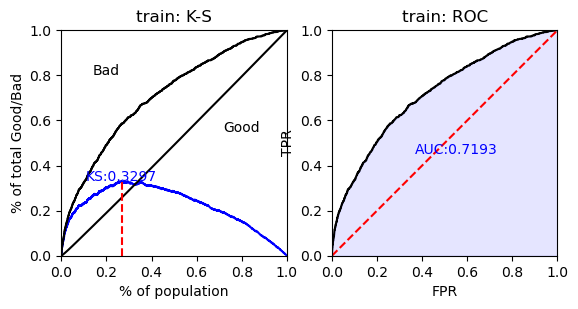

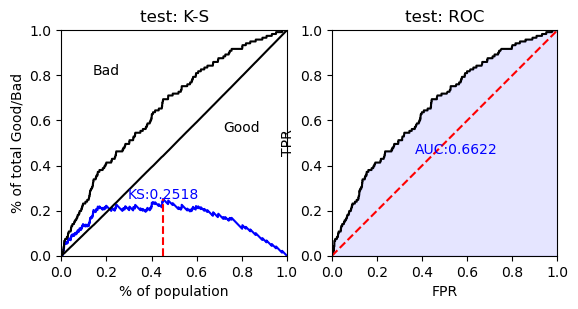

In [11]:
train_perf = sc.perf_eva(y_train, train_proba, title = "train")
test_perf = sc.perf_eva(y_test, test_proba, title = "test")

In [17]:
x_train_transformed.to_pickle("./Intermidiate_data/x_train_logistic.pk")
y_train.to_pickle("./Intermidiate_data/y_train_logistic.pk")
x_train_transformed.to_pickle("./Intermidiate_data/x_test_logistic.pk")
y_test.to_pickle("./Intermidiate_data/y_test_logistic.pk")

with open("./Intermidiate_data/model_logistic.pk", 'wb') as f:
    pickle.dump(pipe.steps[-1][1], f)
